##### Copyright 2019 Qiyang Hu

In [0]:
#@title Licensed under MIT License (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://huqy.github.io/idre_learning_machine_learning/LICENSE.md
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Importing Packages

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

from __future__ import absolute_import, division, print_function, unicode_literals

import os
import time
from shutil import copyfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

TensorFlow 2.x selected.


# Mounting Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Download Data from Kaggle

In [0]:
from google.colab import files
files.upload();

Saving kaggle.json to kaggle.json


In [0]:
!mkdir -p /root/.kaggle
!cp kaggle.json /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!kaggle competitions list -s dogs-vs-cats

ref                                 deadline             category       reward  teamCount  userHasEntered  
----------------------------------  -------------------  ----------  ---------  ---------  --------------  
dogs-vs-cats                        2014-02-01 23:59:00  Playground       Swag        215            True  
dogs-vs-cats-redux-kernels-edition  2017-03-02 23:59:00  Playground  Knowledge       1314            True  


In [0]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition -p /content

 98% 267M/271M [00:02<00:00, 127MB/s]
100% 271M/271M [00:02<00:00, 111MB/s]
 98% 534M/544M [00:08<00:00, 64.7MB/s]
100% 544M/544M [00:08<00:00, 66.4MB/s]
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 132MB/s]


In [0]:
zip_train_dir = tf.keras.utils.get_file('train.zip', origin='file:///content/train.zip', extract=True)
zip_test_dir = tf.keras.utils.get_file('test.zip', origin='file:///content/test.zip', extract=True)

284483584/284478493 [==============================] - 1s 0us/step


# Import image data

#### Using Keras's `flow_from_directory`

![alt text](https://miro.medium.com/max/1400/1*HpvpA9pBJXKxaPCl5tKnLg.jpeg)

In [0]:
train_orig_dir = os.path.join(os.path.dirname(zip_train_dir), 'train')
base_dir = "/content"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

In [0]:
os.makedirs(train_cats_dir)
os.makedirs(train_dogs_dir)
os.makedirs(validation_cats_dir)
os.makedirs(validation_dogs_dir)

In [0]:
filenames = os.listdir(train_orig_dir)
min_index_validation = int(len(filenames)/3) # using 1/3 of training data as validation data
for filename in filenames:
    src = os.path.join(train_orig_dir, filename)
    category = filename.split('.')[0]
    imageId  = filename.split('.')[1]
    extension = filename.split('.')[2]
    if category == 'dog':
        if int(imageId) < min_index_validation:
            dst = os.path.join(train_dogs_dir, imageId+'.'+extension)
        else:
            dst = os.path.join(validation_dogs_dir, imageId+'.'+extension)
    else:
        if int(imageId) < min_index_validation:
            dst = os.path.join(train_cats_dir, imageId+'.'+extension)
        else:
            dst = os.path.join(validation_cats_dir, imageId+'.'+extension)
    copyfile(src, dst)

In [0]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [0]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 8333
total training dog images: 8333
total validation cat images: 4167
total validation dog images: 4167
--
Total training images: 16666
Total validation images: 8334


In [0]:
BATCH_SIZE = 100  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 150  # Our training data consists of images with width of 150 pixels and height of 150 pixels

In [0]:
train_image_generator      = ImageDataGenerator(rescale=1./255)  # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data
test_image_generator       = ImageDataGenerator(rescale=1./255)  # Generator for our validation data

In [0]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')

Found 16666 images belonging to 2 classes.


In [0]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Found 8334 images belonging to 2 classes.


In [0]:
sample_training_images, _ = next(train_data_gen) 

In [0]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

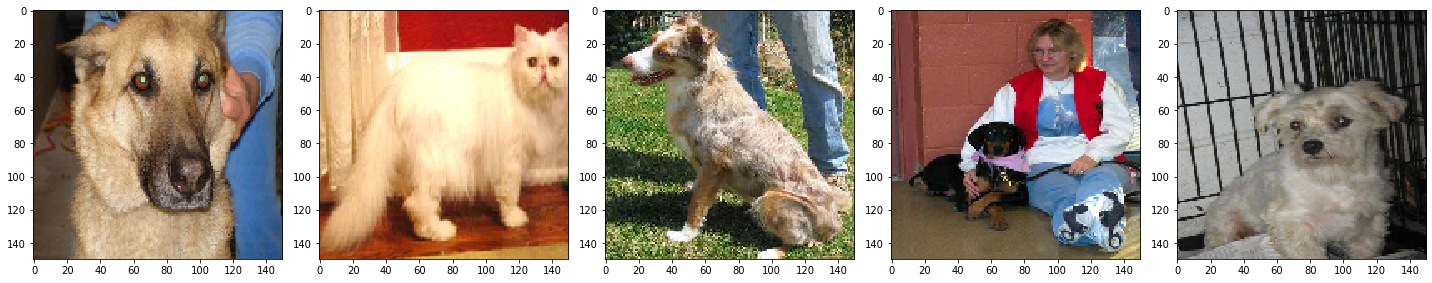

In [0]:
plotImages(sample_training_images[:5])  # Plot images 0-4

# Model Creation

The model structure is mainly adopted from Google's Udacity [Course](https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l05c01_dogs_vs_cats_without_augmentation.ipynb).

## Define a model

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', 
                           input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

## Compile the model

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

# Train the model

**NOTE**: Skip training to **load the model** if time is not long enough to demo the training.

In [0]:
EPOCHS = 50
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/50
167/167 [==============================] - 84s 503ms/step - loss: 0.6680 - accuracy: 0.5737 - val_loss: 0.6179 - val_accuracy: 0.6675
Epoch 2/50
167/167 [==============================] - 78s 466ms/step - loss: 0.5617 - accuracy: 0.7084 - val_loss: 0.4994 - val_accuracy: 0.7586
Epoch 3/50
167/167 [==============================] - 78s 470ms/step - loss: 0.4726 - accuracy: 0.7726 - val_loss: 0.4371 - val_accuracy: 0.7961
Epoch 4/50
167/167 [==============================] - 78s 470ms/step - loss: 0.4078 - accuracy: 0.8156 - val_loss: 0.4298 - val_accuracy: 0.8029
Epoch 5/50
167/167 [==============================] - 78s 468ms/step - loss: 0.3617 - accuracy: 0.8387 - val_loss: 0.3690 - val_accuracy: 0.8373
Epoch 6/50
167/167 [==============================] - 78s 469ms/step - loss: 0.3209 - accuracy: 0.8588 - val_loss: 0.3693 - val_accuracy: 0.8357
Epoch 7/50
167/167 [==============================] - 78s 465ms/step - loss: 0.2797 - accuracy: 0.8786 - val_loss: 0.3146 - val_ac

## Visualizing results of the training

In [0]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

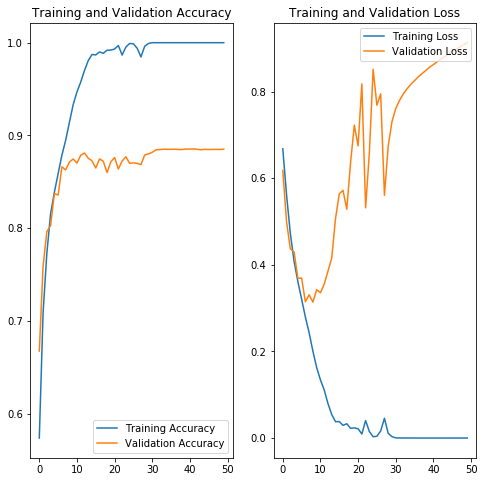

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

## Save the model

In [0]:
t = time.time()
savedmodel_dir = "/content/drive/My Drive/saved_model/dogcats/plain/{}".format(int(t))
print(savedmodel_dir)

/content/drive/My Drive/saved_model/dogcats/plain/1573066395


In [0]:
model.save(savedmodel_dir)

In [0]:
os.listdir(savedmodel_dir)

['variables', 'assets', 'saved_model.pb']

## Load the model

In [0]:
# load the model saved before
t = 1573066395
savedmodel_dir = "/content/drive/My Drive/saved_model/dogcats/plain/{}".format(int(t))
new_model = tf.keras.models.load_model(savedmodel_dir)
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

# Predict the model

## Preparing the test data

In [0]:
test_orig_dir = os.path.join(os.path.dirname(zip_test_dir), 'test')
base_dir = "/content"
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir)

filenames = os.listdir(test_orig_dir)
for filename in filenames:
    src = os.path.join(test_orig_dir, filename)
    dst = os.path.join(test_dir, filename)
    copyfile(src, dst)
    
test_filenames = os.listdir(test_dir)
nb_samples = len(filenames)
    
print("Total test images:", nb_samples)

Total test images: 12500


In [0]:
ids = []
for fullfilename in test_filenames:
    filename = os.path.basename(fullfilename)
    ids.append(os.path.splitext(filename)[0])

## Using `flow_from_dataframe` method

In [0]:
test_df = pd.DataFrame({
    'filename': test_filenames,
    'id': ids
})
nb_samples = test_df.shape[0]
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    test_dir, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(IMG_SHAPE,IMG_SHAPE),
    batch_size=1,
    shuffle=False
)

Found 12500 validated image filenames.


In [0]:
predict = new_model.predict_generator(test_generator, steps=nb_samples)

In [0]:
test_df['label'] = predict[:,1]
test_df.head()

,filename,id,label
0,10129.jpg,10129,1.268359e-03
1,1703.jpg,1703,9.999996e-01
2,240.jpg,240,1.000000e+00
3,4401.jpg,4401,9.780292e-01
4,5664.jpg,5664,7.998054e-20


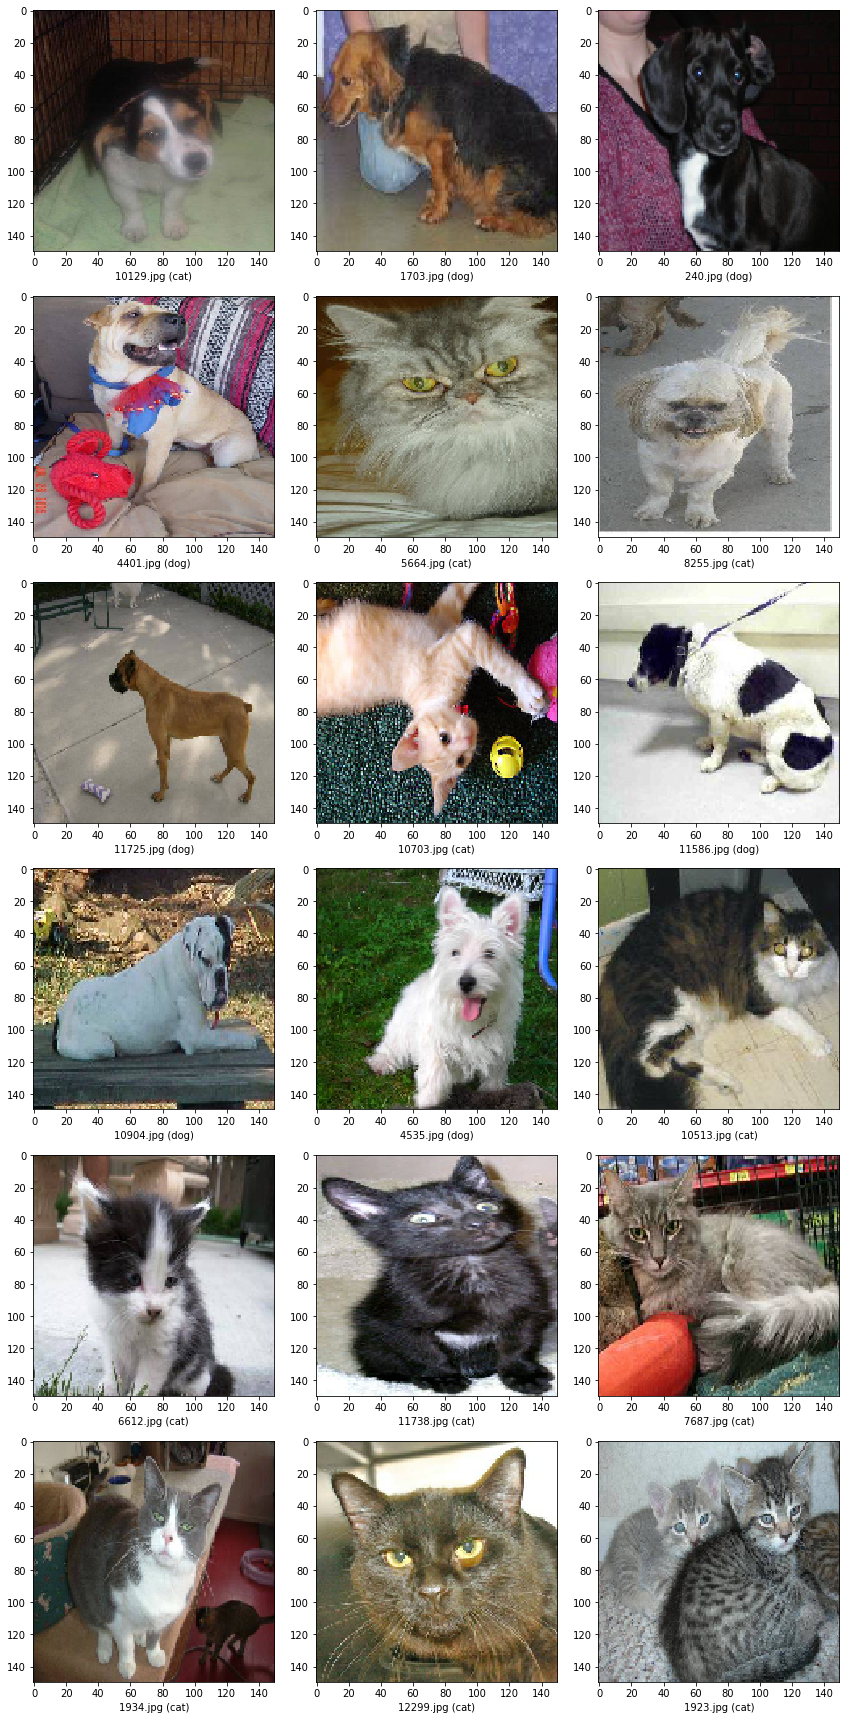

In [0]:
sample_test = test_df.head(18)
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    id = row['id']
    category = "dog" if row['label'] >= 0.5 else "cat"
    img = load_img('test/'+filename, target_size=(IMG_SHAPE,IMG_SHAPE))
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(id + '.jpg (' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

# Submission to Kaggle

In [0]:
test_df[['id','label']].to_csv('withoutDataAug_4.csv', index=False)

In [0]:
!kaggle competitions submit -c dogs-vs-cats-redux-kernels-edition -f withoutDataAug_4.csv -m "My fourth submission without data augmentation"

100% 183k/183k [00:02<00:00, 82.4kB/s]
Successfully submitted to Dogs vs. Cats Redux: Kernels Edition